Do `Kernel -> Restart & Run All` in top menu to run the notebook

In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, resample, convolve, tf2zpk
import soundfile as sf
import IPython
from mpl_toolkits.mplot3d import Axes3D

## Speech + noise

In [3]:
# read the speech
data, fs = sf.read('data/050a0508_1.4465_22gc0102_-1.4465.wav')
# create white noise
noise_all = np.random.randn(data.shape[0])
# filter the noise to have it around 800 Hz
b, a = butter(5, [0.2, 0.25], 'bandpass')
noise_narrow  = lfilter(b, a, noise_all)
# add noise to the speech
data_noise = data + noise_narrow

In [4]:
# create bandstop filter to filter out frequencies corrupted by the noise
b, a = butter(5, [0.15, 0.3], 'bandstop')
data_filt = lfilter(b, a, data_noise)

In [5]:
print('Clean speech')
IPython.display.display(IPython.display.Audio(data, rate=fs))
print('Corrupted speech')
IPython.display.display(IPython.display.Audio(data_noise, rate=fs))
print('Filtered speech')
IPython.display.display(IPython.display.Audio(data_filt, rate=fs))

Clean speech


Corrupted speech


Filtered speech


In [6]:
# Compute the spectra
spec = np.fft.fft(data)
spec_noise = np.fft.fft(data_noise)
spec_filt = np.fft.fft(data_filt)

In [7]:
# Get frequency response of the filter
w,h = freqz(b,a)

<IPython.core.display.Javascript object>


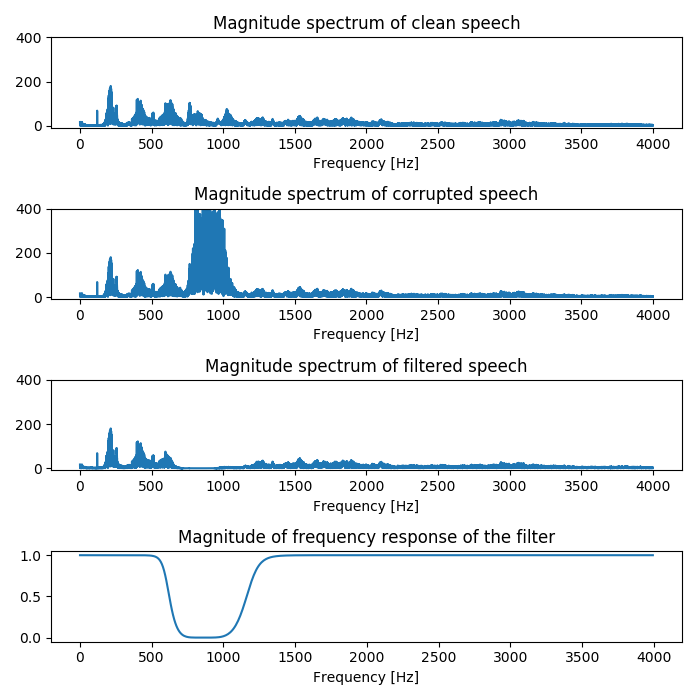

In [8]:
# Plot the magnitude spectra
f = np.linspace(0,4000,spec_filt.shape[0]//2+1)
fig, ax = plt.subplots(4,1, figsize=(7,7))
for ax0 in ax[:-1]:
    ax0.set_ylim([-10, 400])
ax[0].plot(f,np.abs(spec)[:f.shape[0]])
ax[0].set_title('Magnitude spectrum of clean speech')
ax[0].set_xlabel('Frequency [Hz]')
ax[1].plot(f,np.abs(spec_noise)[:f.shape[0]])
ax[1].set_title('Magnitude spectrum of corrupted speech')
ax[1].set_xlabel('Frequency [Hz]')
ax[2].plot(f,np.abs(spec_filt)[:f.shape[0]])
ax[2].set_title('Magnitude spectrum of filtered speech')
ax[2].set_xlabel('Frequency [Hz]')
ax[3].plot(8000*w/2/np.pi,np.abs(h))
ax[3].set_title('Magnitude of frequency response of the filter')
ax[3].set_xlabel('Frequency [Hz]')
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


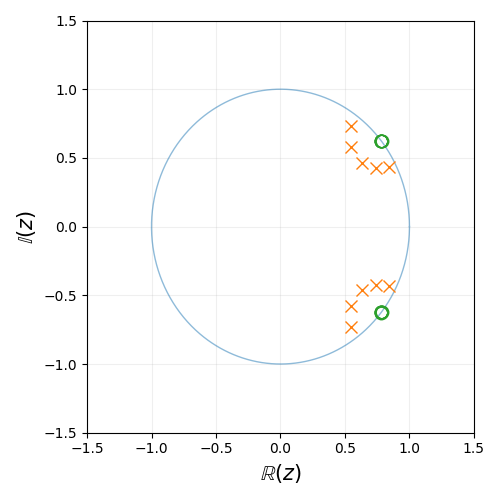

In [9]:
(n,p,k) = tf2zpk(b,a)

plt.figure(figsize=(5,5))
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.xlabel('$\mathbb{R}(z)$', fontsize=15)
plt.ylabel('$\mathbb{I}(z)$', fontsize=15)

# jednotkova kruznice
ang = np.linspace(0,2*np.pi,1000)
plt.plot(np.cos(ang), np.sin(ang), linewidth=1, alpha=0.5)

# vykresleni nul a polu
plt.plot(p.real, p.imag, 'x', markersize=9)
plt.plot(n.real, n.imag, 'o', markersize=9, markerfacecolor='None')

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [10]:
# ugly implementation
# probably there's a scipy function for this?
def transfer_func(z, n, p):
    nom = 1
    for i in range(n.shape[0]):
        nom *= (z-n[i])
    denom = 1
    for i in range(p.shape[0]):
        denom *= (z-p[i])
    return nom / denom

In [11]:
x = np.arange(-1.5, 1.5, 0.1)
y = np.arange(-1.5, 1.5, 0.1)
X,Y = np.meshgrid(x,y)
tr_f = transfer_func(X + 1j*Y, n, p)

thresh = 10

<IPython.core.display.Javascript object>


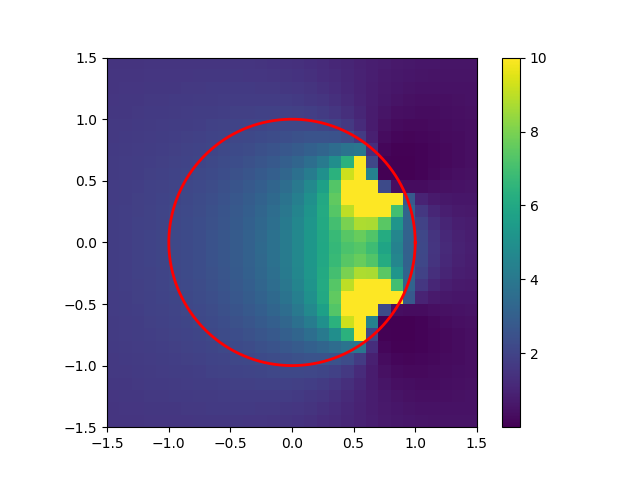

In [12]:
fig = plt.figure()
f = plt.imshow(np.minimum(np.abs(tr_f), thresh), interpolation='none', extent=[-1.5,1.5,-1.5,1.5])
plt.colorbar()
cmap = f.get_cmap()

# unit circle
ang = np.linspace(0,2*np.pi,1000)
plt.plot(np.cos(ang), np.sin(ang), linewidth=2, color='red')

plt.show()

<IPython.core.display.Javascript object>


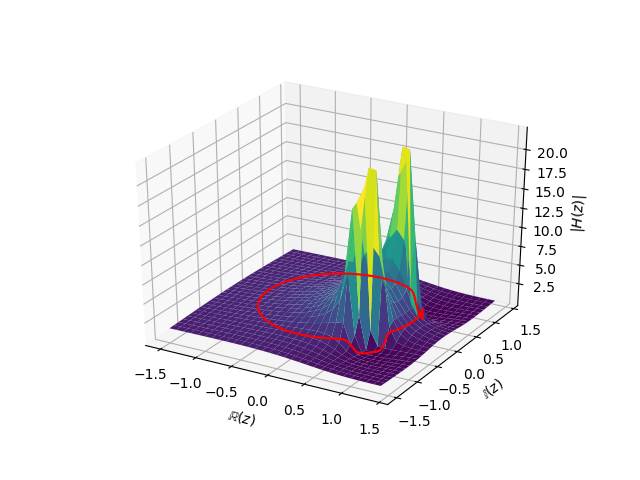

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, np.minimum(np.abs(tr_f),100), cmap=cmap)
tr_f_unit_circ = transfer_func(np.cos(ang) + 1j*np.sin(ang), n, p)
ax.plot(np.cos(ang), np.sin(ang), np.minimum(np.abs(tr_f_unit_circ),10), color='red')
ax.set_xlabel('$\mathbb{R}(z)$')
ax.set_ylabel('$\mathbb{I}(z)$')
ax.set_zlabel('$|H(z)|$')
plt.show()